In [254]:
from __future__ import division, print_function

import time, datetime

import numpy as np

from astropy.modeling import models

In [4]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import rcParams

rcParams['figure.figsize'] = (16, 10)
rcParams['image.interpolation'] = 'none'
rcParams['image.origin'] = 'lower'

# Experiment w/ distributions 

$\frac{dn}{dm}= A n^\alpha \rightarrow N = \int^{m_2}_{m_1}{A n^\alpha}= \left. \frac{A}{\alpha+1} n^{\alpha+1} \right\rvert^{m_2}_{m_1} = \frac{A}{\alpha+1} \left(m_2^{\alpha+1} - m_1^{\alpha+1}\right)$

$A$ for normalization: $\int^{m2}_{m1} An^{\alpha}=1 \rightarrow A=\frac{\alpha+1}{m_2^{\alpha+1}-m_1^{\alpha+1}} \rightarrow \frac{\alpha+1}{A} = m_2^{\alpha+1}-m_1^{\alpha+1}$

For CDF from $m_1$ to $x$, need to sample N on [0,1] and then evaluate it as:
$x \; (=m2) = \left(\frac{N (\alpha+1)}{A}+m_1^{\alpha+1} \right)^{\frac{1}{\alpha+1}} = 
 \left[ N \left( m_2^{\alpha+1} - m_1^{\alpha+1} \right) + m_1^{\alpha+1} \right]^{\frac{1}{\alpha+1}}=
 \left[ N m_2^{\alpha+1} + (1-N)m_1^{\alpha+1}   \right]^{\frac{1}{\alpha+1}}$

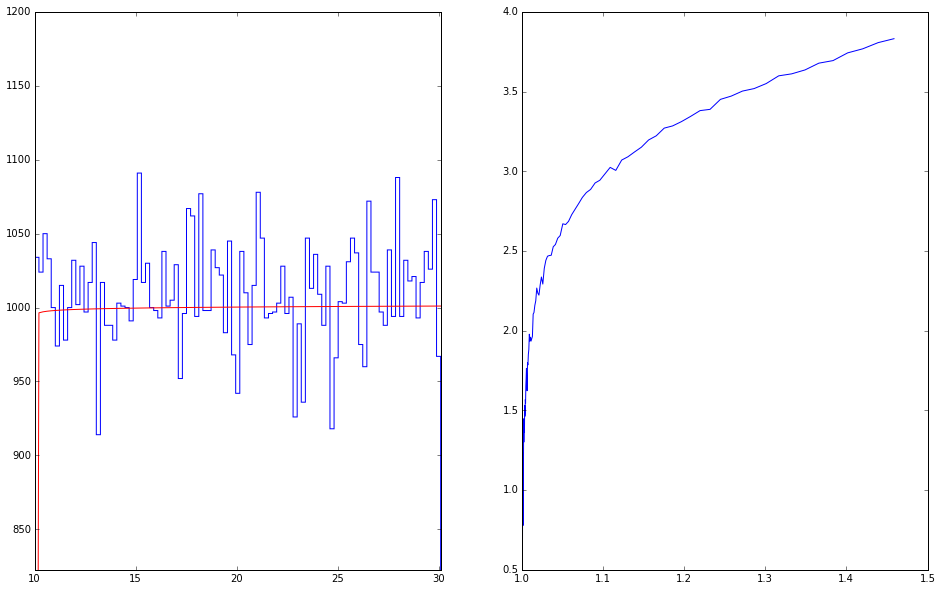

In [133]:
alpha = 0.001
m1, m2 = 10,30.1

nsamp = 100000
samples = np.random.power(alpha+1, nsamp)*(m2-m1)+m1

bins = np.linspace(m1, m2, 100)
lbins = np.logspace(-3, 0, 100)*(m2-m1)+m1

plt.subplot(1, 2, 1)
ninbin = plt.hist(samples, bins=bins,histtype='step')[0]
y = (alpha+1)*((bins-m1)/(m2-m1))**alpha
plt.plot(bins, y*np.mean(ninbin)*np.mean(y), c='r')
plt.xlim(m1, m2)
plt.ylim(np.min(ninbin)*.9, np.max(ninbin)*1.1)

plt.subplot(1, 2, 2)
ninbin = np.histogram(samples, bins=lbins)[0]
plt.plot(np.log10(lbins[:-1]), np.log10(ninbin))

WRONG KIND OF POWER LAW!

## Exponential 

$$\frac{dn}{dm}=A 10^{a (m-\mu)}=A e^{a \ln(10) (m-\mu)}=A e^{\alpha (m-\mu)}$$ wher $\alpha \equiv a \ln(10)$

$$
N= \int^{m_2}_{m_1} A e^{\alpha(m-\mu)} dm = \left. \frac{A}{\alpha} e^{\alpha(m-\mu)} \right\rvert_{m_1}^{m_2}=
\frac{A}{\alpha} e^{-\alpha \mu} \left[ e^{\alpha m_2}-e^{\alpha m_1} \right]
$$

Now we get A for the [$m_1$, $m_2$] range:
$$
N=1 \rightarrow A=\frac{\alpha e^{\alpha \mu}}{e^{\alpha m_2}-e^{\alpha m_1}}
$$

So the final distribution from $m_1$ to $x$ is:
    $$
    N = \frac{e^{\alpha x}-e^{\alpha m_1}}{e^{\alpha m_2}-e^{\alpha m_1}} \rightarrow
    N (e^{\alpha m_2}-e^{\alpha m_1}) + e^{\alpha m_1} = e^{\alpha x} \rightarrow
    x = \frac{1}{\alpha} \ln{\left[ N (e^{\alpha m_2}-e^{\alpha m_1}) + e^{\alpha m_1} \right]}
    $$

In [426]:
def sample_lf(nsamples, alpha, m1, m2):
    N = np.random.rand(nsamples)
    expa1 = np.exp(alpha*m1)
    expa2 = np.exp(alpha*m2)
    return np.log(N*(expa2-expa1)+expa1)/alpha

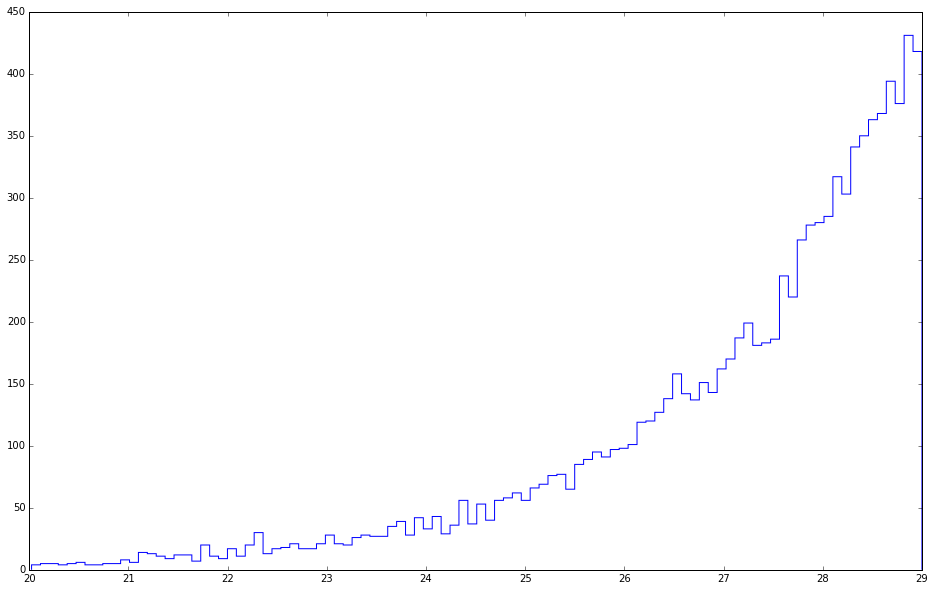

In [432]:
plt.hist(sample_lf(10000, .5, 20, 29), bins=100, histtype='step')
None

# Emceemr tests 

In [134]:
import emceemr
from emceemr import priors
import rgbmcmr

In [433]:
def make_fake_rgb(alpha, beta, mu, brightlimit, faintlimit, nmax, fracrgb):
    """
    
    returns mag0, isrgb
    """    
    #a = alpha + 1
    #b = beta + 1    
    #rgb = np.random.power(a, nmax)*(faintlimit-brightlimit) + brightlimit
    #foreground = np.random.power(b, nmax)*(faintlimit-brightlimit) + brightlimit
    
    rgb = sample_lf(nmax, alpha, brightlimit, faintlimit)
    foreground = sample_lf(nmax, beta, brightlimit, faintlimit)
    
    rgbmsk = rgb>mu
    fgmsk = foreground<mu
    rgb = rgb[rgbmsk]
    foreground = foreground[fgmsk]
    
    starting_fracrgb = len(rgb)/(len(foreground)+len(rgb))
    if starting_fracrgb>fracrgb:
        #too many RGBs
        nrgb = len(foreground)*fracrgb/(1-fracrgb)
        rgb = rgb[:nrgb]
    else:
        #too many fgs
        nfg = len(rgb)*(1-fracrgb)/fracrgb
        foreground = foreground[:nfg]
    
    mags = np.concatenate((rgb, foreground))
    isrgb = np.zeros(len(mags), dtype=bool)
    isrgb[:len(rgb)] = True
    
    unsorti = np.random.permutation(len(mags))
    mags = mags[unsorti]
    isrgb = isrgb[unsorti]
    
    return mags, isrgb

In [544]:
#median absolute deviation from ASTs
madmodel = models.Legendre1D(20, c0=-3954355396.3633738, c1=1353694208.4087687, c2=-124848799.79526304, c3=4897226.378521032, c4=-57041.00249220571, c5=-1549.1100474853888, c6=30.190195895799725, c7=1.1368681316643618, c8=-0.03563103282644921, c9=6.0712498989515646e-05, c10=4.892644246415783e-06, c11=8.248737934921185e-08, c12=-2.3350690477921424e-09, c13=-1.8352224226398223e-11, c14=5.350673251357965e-13, c15=2.4468515243894513e-15, c16=2.6121935517894807e-17, c17=-4.622081469223215e-18, c18=8.23871918441632e-20, c19=-6.005849952016176e-22, c20=1.6539943309668438e-24)

a= 0.690775527898


(294, 54, 0.84482758620689657)

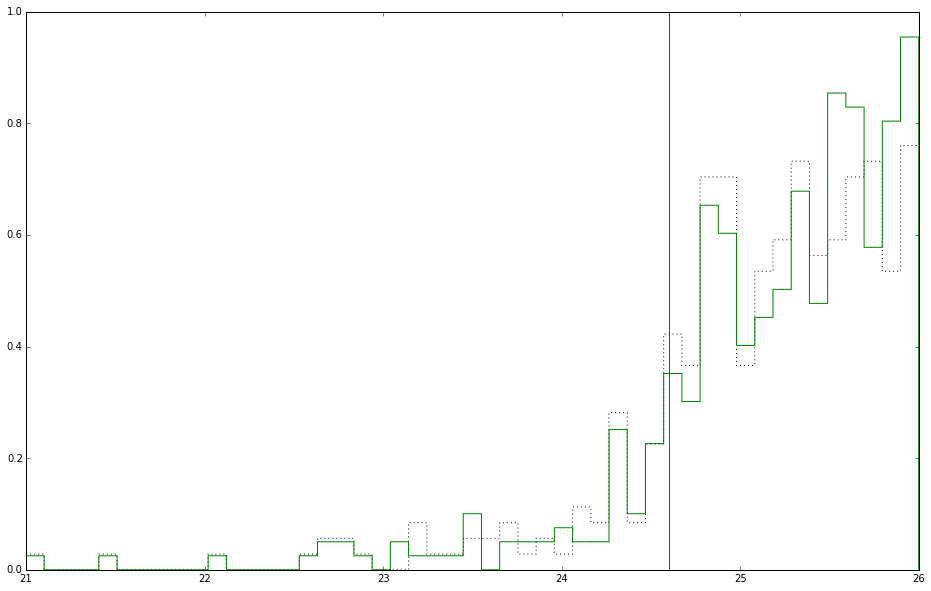

In [630]:
a = np.log(10)*.3
print('a=',a)
b = 1
mu = 24.6

realmags, isrgb = make_fake_rgb(a, b, mu, 21, 29, 5000, .986)

asterrs = madmodel(realmags)*1.483
asterrmags = realmags+np.random.randn(len(realmags))*asterrs


bins = np.linspace(21,26,50)
plt.hist(realmags, bins=bins,histtype='step',normed=True, ls='dotted', color='k')
plt.hist(asterrmags, bins=bins,histtype='step',normed=True, color='g')

inwindow = (bins[0]<realmags)&(realmags<bins[-1])
inrgbwindow = inwindow&(realmags>mu)
inotherwindow = inwindow&(realmags<mu)

plt.axvline(mu,color='r')
np.sum(inrgbwindow), np.sum(inotherwindow), np.sum(inrgbwindow)/np.sum(inwindow)

## Now do test runs of the MCMC

In [631]:
pris = dict(tipmag=priors.UniformPrior(23, 25.5),
            alphargb=priors.UniformPrior(0, 5), 
            alphaother=priors.UniformPrior(0, 5),
            fracother=priors.UniformPrior(0,0.5))

### "Intrinsic" mags 

In [632]:
astmod = rgbmcmr.RGBModel(realmags[inwindow], None, priors=pris)

In [633]:
print('Starting at', datetime.datetime.now())
st = time.time()
sampler = astmod.initialize_and_sample(5000, burnin=1000)
et = time.time()
dt = (et - st)*u.second
print('Took',dt.to(u.minute))

Starting at 2015-11-12 20:04:04.168546
Took 0.103006581465 min


Acors:
tipmag: 55.4714857614
alphargb: 49.4494826404
alphaother: 50.2261155727
fracother: 56.3664640385
Acceptance Fractions:
[ 0.45  ,  0.4632,  0.4708,  0.4772,  0.471 ,  0.4834,  0.4566,  0.4548,
  0.4702,  0.4728,  0.4842,  0.4696,  0.4708,  0.4596,  0.4836,  0.4766]


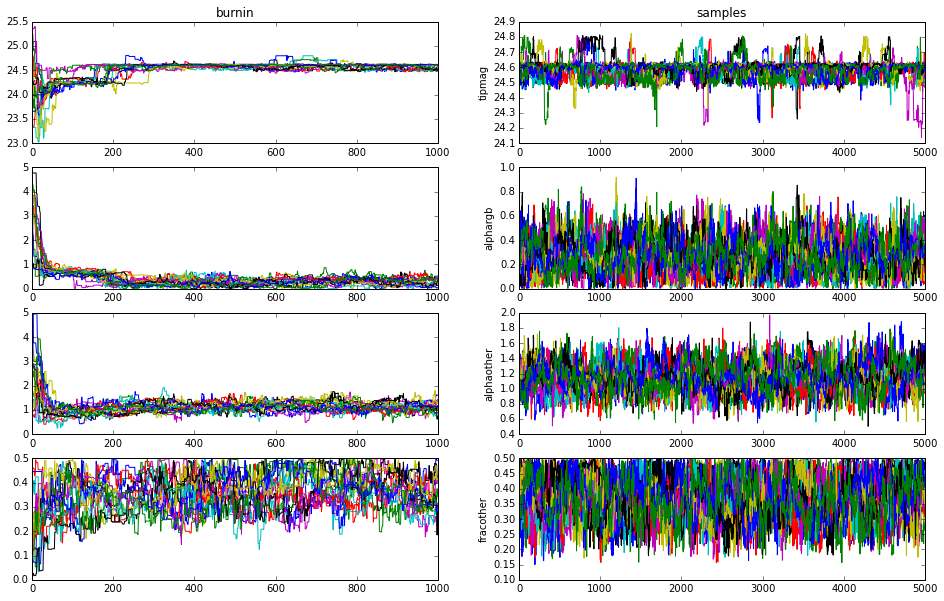

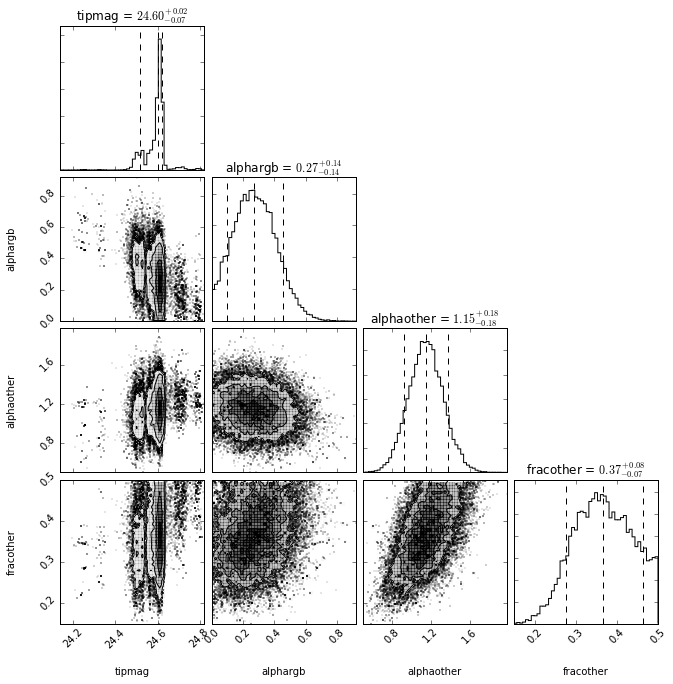

In [634]:
plt.figure()
emceemr.plot_chains(astmod, sampler,incl_burnin=True)
plt.figure()
emceemr.triangle_plot(astmod, sampler, quantiles=[.1, .5, .9], show_titles=True, verbose=False)

print(emceemr.sampler_info_string(astmod, sampler))

### With AST 

In [635]:
astmod = rgbmcmr.RGBModel(asterrmags[inwindow], madmodel(asterrmags[inwindow])*1.483, priors=pris)

In [636]:
#experimental timing run
st = time.time()
sampler = astmod.initialize_and_sample(15, burnin=5)
et = time.time()
dt = (et - st)*u.second
    
ntarg = 6000
print('20 samples took', dt, 'which scales up to',ntarg,'samples in',(dt*ntarg/20).to(u.minute))

20 samples took 0.0972499847412 s which scales up to 6000 samples in 0.486249923706 min


In [637]:
#now the real deal
print('Starting at', datetime.datetime.now())
st = time.time()
sampler = astmod.initialize_and_sample(5000, burnin=1000)
et = time.time()
dt = (et - st)*u.second
print('Took',dt.to(u.minute))

Starting at 2015-11-12 20:04:14.195313
Took 0.456215735277 min


Acors:
tipmag: 49.1280122476
alphargb: 56.0115892736
alphaother: 54.3288141811
fracother: 57.5952184686
Acceptance Fractions:
[ 0.5198,  0.5454,  0.5064,  0.5248,  0.537 ,  0.5362,  0.5228,  0.5156,
  0.5096,  0.5348,  0.5292,  0.494 ,  0.5384,  0.5192,  0.5112,  0.5064]


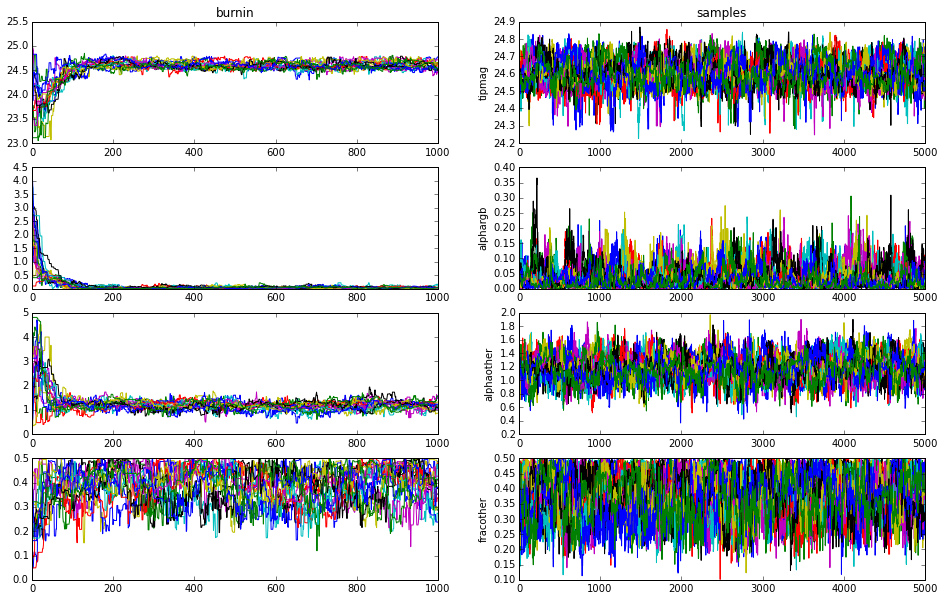

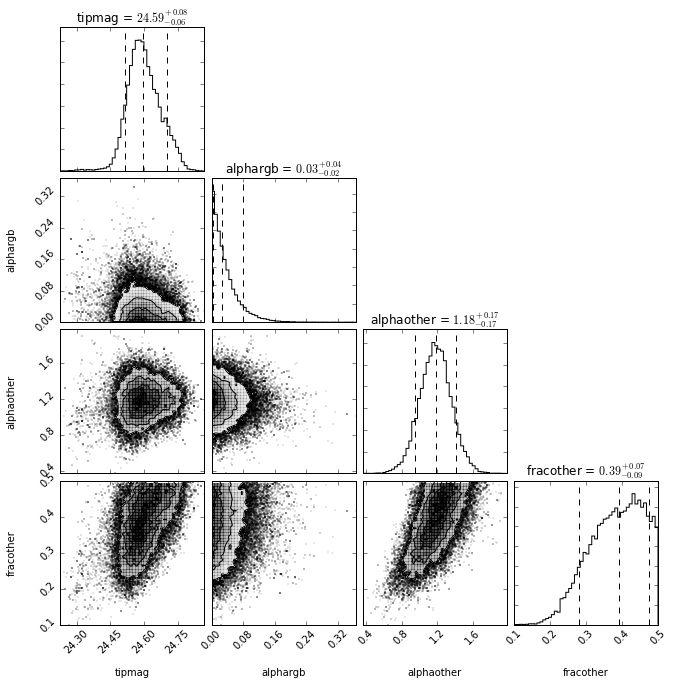

In [638]:
plt.figure()
emceemr.plot_chains(astmod, sampler,incl_burnin=True)
plt.figure()
emceemr.triangle_plot(astmod, sampler, quantiles=[.1, .5, .9], show_titles=True, verbose=False)

print(emceemr.sampler_info_string(astmod, sampler))

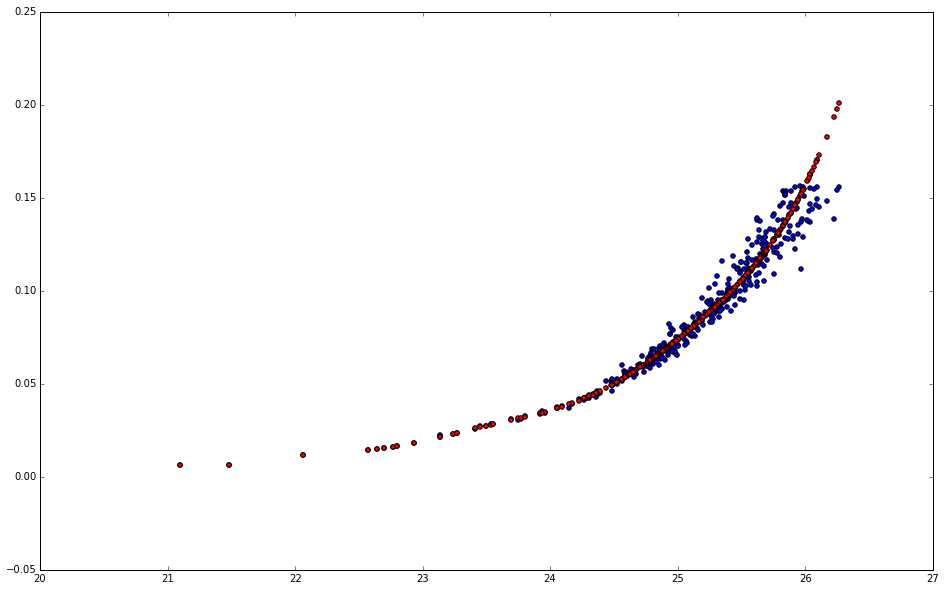

In [639]:
plt.scatter(asterrmags[inwindow], asterrs[inwindow])
plt.scatter(asterrmags[inwindow], madmodel(asterrmags[inwindow])*1.483,c='r')